In [ ]:
# use wandb artifact

import wandb

run = wandb.init(project="FedSPK", job_type="evaluate_tsne")

artifact = run.use_artifact("FedSPK:latest", type="model")
artifact_dir = artifact.download()


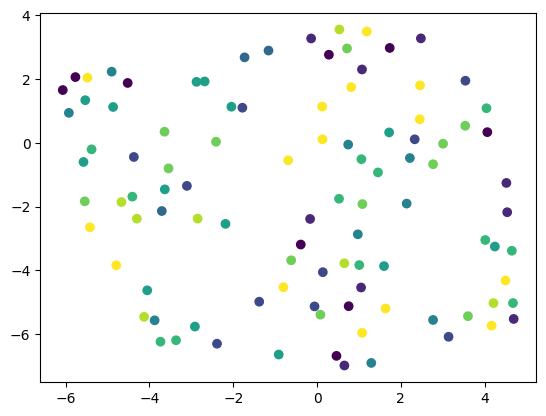

In [1]:
# use sklearn TSEN to visualize the embedding
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# create random embedding and class label
embedding = np.random.rand(100, 2)
label = np.random.randint(0, 10, 100)

# create TSNE model
tsne = TSNE(n_components=2, random_state=0)

# use TSNE to reduce dimension for embedding
embedding_2d = tsne.fit_transform(embedding)

# visualize the embedding
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=label)
plt.show()

